[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/object_detection/yolo_v1/runner.ipynb)

In [1]:
!git clone https://github.com/khetansarvesh/CV.git

Cloning into 'CV'...
remote: Enumerating objects: 1252, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 1252 (delta 135), reused 177 (delta 123), pack-reused 1053 (from 1)
Receiving objects: 100% (1252/1252), 96.24 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (738/738), done.


In [2]:
import os
import csv
from tqdm import tqdm
import numpy as np

# pytorch library
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision

In [3]:
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
print(DEVICE)

cuda


# **Dataset**

In [4]:
# GETTING VOC2007 TRAIN DATASET and EXTRACTING TAR FILES
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar xf VOCtrainval_06-Nov-2007.tar

# GETTING VOC2012 TRAIN DATASET and EXTRACTING TAR FILES
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar xf VOCtrainval_11-May-2012.tar

# GETTING VOC2007 TEST DATASET and EXTRACTING TAR FILES
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar #
!tar xf VOCtest_06-Nov-2007.tar

# Gettting the images location for 2007 (both train and test) and 2012 (only train) in txt files
!wget https://pjreddie.com/media/files/voc_label.py
!python voc_label.py

--2024-11-25 21:47:10--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  7.85MB/s    in 39s     

2024-11-25 21:47:49 (11.3 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2024-11-25 21:47:51--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[==========

In [5]:
# creating a new folder data which will contain all the images and labels
!mkdir data
!mkdir data/images
!mkdir data/labels

!mv VOCdevkit/VOC2007/JPEGImages/*.jpg data/images/
!mv VOCdevkit/VOC2012/JPEGImages/*.jpg data/images/
!mv VOCdevkit/VOC2007/labels/*.txt data/labels/
!mv VOCdevkit/VOC2012/labels/*.txt data/labels/

Creating Training Dataset

In [6]:
# training data will consist of 2007_train + 2007_val + 2012_train + 2012_val, concatenating all of these and storing in train.txt
!cat 2007_train.txt 2007_val.txt 2012_*.txt > train.txt

# converting this traing.txt file to csv file
read_train = open("train.txt", "r").readlines()
with open("train.csv", mode="w", newline="") as train_file:
    for line in read_train:
        image_file = line.split("/")[-1].replace("\n", "")
        text_file = image_file.replace(".jpg", ".txt")
        data = [image_file, text_file]
        writer = csv.writer(train_file)
        writer.writerow(data)

In [7]:
from CV.object_detection.yolo_v1.dataset import VOCDataset
train_dataset = VOCDataset("train.csv", img_dir="data/images", label_dir="data/labels")

# creating training dataloader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    num_workers=2,
    pin_memory=True,
    shuffle=True,
    drop_last=True)

Creating Testing Dataset

In [8]:
# testing data will consist of 2007_test
!cp 2007_test.txt test.txt

# converting this test.txt file to csv file
read_train = open("test.txt", "r").readlines()
with open("test.csv", mode="w", newline="") as train_file:
    for line in read_train:
        image_file = line.split("/")[-1].replace("\n", "")
        text_file = image_file.replace(".jpg", ".txt")
        data = [image_file, text_file]
        writer = csv.writer(train_file)
        writer.writerow(data)

In [9]:
# testing dataset
test_dataset = VOCDataset("test.csv", img_dir="data/images", label_dir="data/labels")

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=16,
    num_workers=2,
    pin_memory=True,
    shuffle=True,
    drop_last=True)

Cleaning Up to save some ram space

In [10]:
! rm 2007* 2012* *.txt *.tar *.py
! rm -rf VOCdevkit/

rm: cannot remove '2007_test.txt': No such file or directory
rm: cannot remove '2007_train.txt': No such file or directory
rm: cannot remove '2007_val.txt': No such file or directory
rm: cannot remove '2012_train.txt': No such file or directory
rm: cannot remove '2012_val.txt': No such file or directory


# **Modelling**

In [11]:
class YOLOV1(nn.Module):

    def __init__(self):
        super(YOLOV1, self).__init__()

        backbone = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4,
        )


        self.conv_yolo_layers = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1, bias=False), nn.BatchNorm2d(1024), nn.LeakyReLU(0.1), #512 cause resnet gives 512 channel output
            nn.Conv2d(1024, 1024, 3, stride=2, padding=1, bias=False), nn.BatchNorm2d(1024), nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1, bias=False),nn.BatchNorm2d(1024),nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1, bias=False),nn.BatchNorm2d(1024),nn.LeakyReLU(0.1)
            )

        self.fc_yolo_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7 * 7 * 1024, 4096),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(4096, 7 * 7 * (5 * 2 + 20)),
        )
        # instead of this you could have also used a 1*1 convolution layer as follows
        # self.fc_yolo_layers = nn.Sequential( nn.Conv2d(1024, 5 * self.B + self.C, 1))

    def forward(self, x):
        out = self.features(x)
        out = self.conv_yolo_layers(out)
        out = self.fc_yolo_layers(out)
        return out

In [ ]:
# class YOLOV1(nn.Module):

#     def __init__(self):
#         super(YOLOV1, self).__init__()

#         S = 7
#         C = 20
#         B = 2


#         self.darknet = nn.Sequential(

#         nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False), nn.BatchNorm2d(64), nn.LeakyReLU(0.1),
#         nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

#         nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(192), nn.LeakyReLU(0.1),
#         nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

#         nn.Conv2d(192, 128, kernel_size=1, stride=1, padding=0, bias=False), nn.BatchNorm2d(128), nn.LeakyReLU(0.1),
#         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.1),
#         nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.1),
#         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.1),
#         nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

#         nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.1),
#         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.1),
#         nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.1),
#         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.1),
#         nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.1),
#         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.1),
#         nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.1),
#         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.1),
#         nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.1),
#         nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(1024), nn.LeakyReLU(0.1),
#         nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

#         nn.Conv2d(1024, 512, kernel_size=1, stride=1, padding=0, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.1),
#         nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(1024), nn.LeakyReLU(0.1),
#         nn.Conv2d(1024, 512, kernel_size=1, stride=1, padding=0, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.1),
#         nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(1024), nn.LeakyReLU(0.1),


#         nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(1024), nn.LeakyReLU(0.1),
#         nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1, bias=False), nn.BatchNorm2d(1024), nn.LeakyReLU(0.1),
#         nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(1024), nn.LeakyReLU(0.1),
#         nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(1024), nn.LeakyReLU(0.1),
#         )

#         self.fcs = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(1024 * S * S, 4096),
#             nn.Dropout(0.0),
#             nn.LeakyReLU(0.1),
#             nn.Linear(4096, S * S * (C + B * 5)),
#         )

#     def forward(self, x):
#         x = self.darknet(x)
#         x = torch.flatten(x, start_dim=1)
#         x = self.fcs(x)
#         return x

In [12]:
model = YOLOV1().to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 207MB/s]


# **Training**

In [13]:
# Setting Seed
seed = 123
torch.manual_seed(seed)

# Setting Optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0)

# import loss function
from CV.object_detection.yolo_v1.loss import YoloLoss

In [14]:
for epoch in range(2):

    mean_loss = []
    loop = tqdm(train_loader, leave=True)

    for batch_idx, (x, y) in enumerate(loop):

        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)

        loss = YoloLoss(7,2,20,out, y)

        mean_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

100%|██████████| 1034/1034 [07:29<00:00,  2.30it/s, loss=97.3]


Mean loss was 211.79056204495163


100%|██████████| 1034/1034 [07:30<00:00,  2.29it/s, loss=102]

Mean loss was 133.2939301865244


# **Inference**
Since I was low on compute, I trained the model only for 2 epoch and hence you will find the predicted bounding boxes are not good, but if you train this exact model for a large no of epochs, this same code will give amazing results!!

In [15]:
from CV.object_detection.yolo_v1.nms import non_max_suppression
from CV.object_detection.yolo_v1.infer import (plot_image, cellboxes_to_boxes)

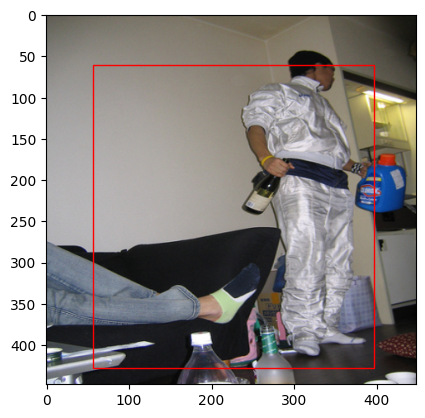

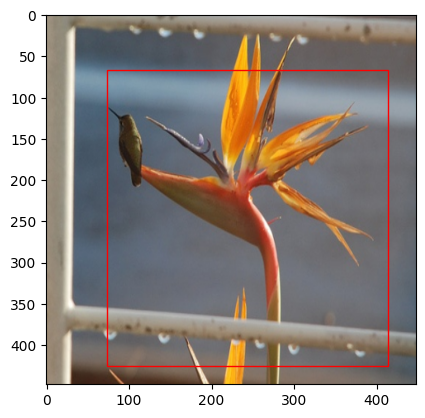

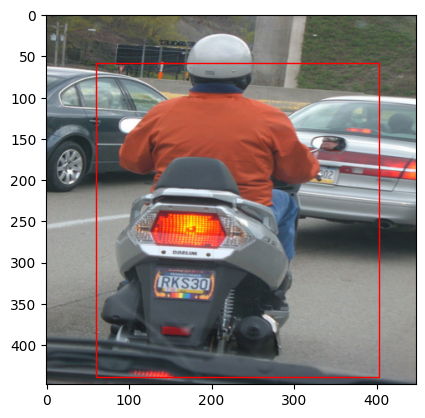

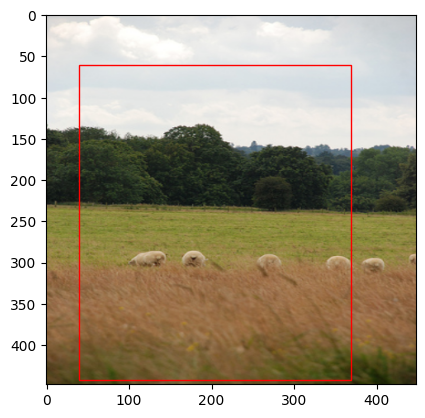

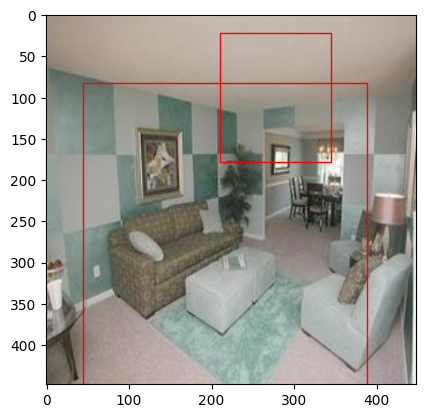

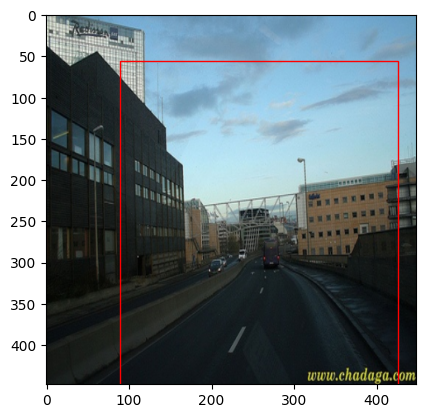

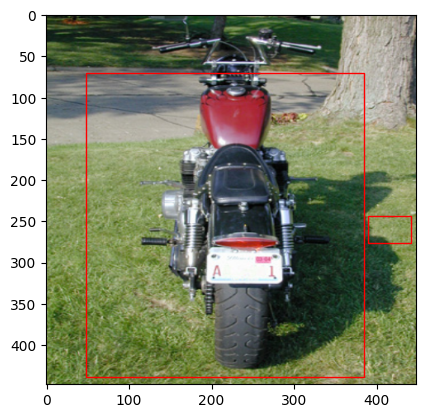

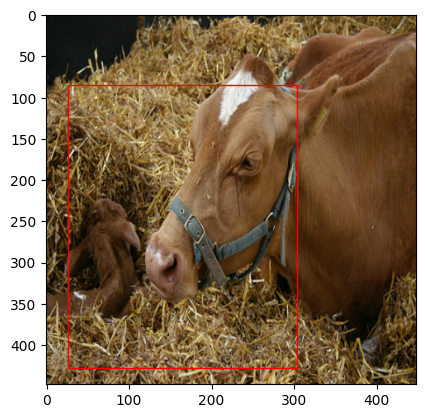

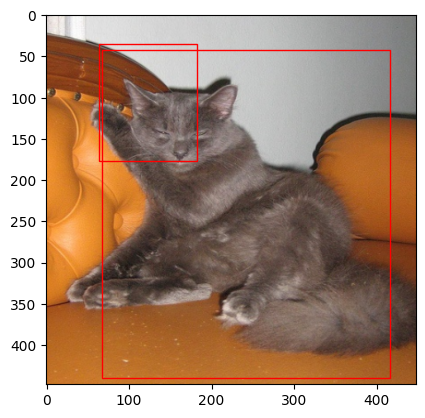

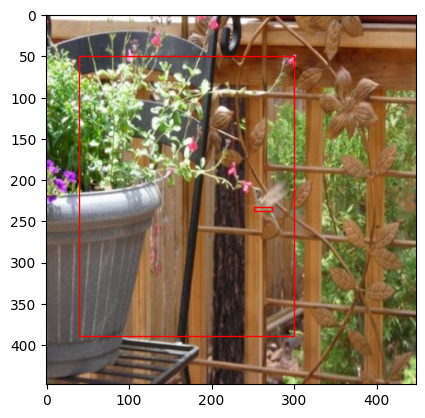

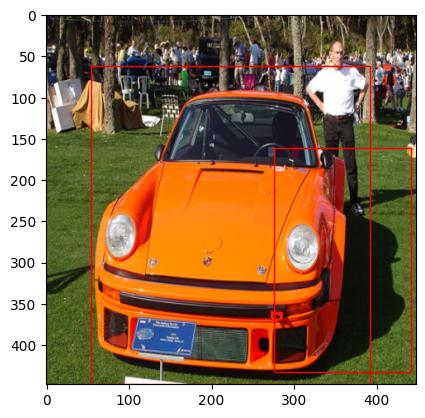

In [16]:
# since I did not have a huge compute i did not train the model for a long time and hence it will not perform well on test dataset,
# hence to visualize we will perform testing on 10 train dataset images itself !!

count = 0

for im, _ in train_loader:

  if count <=10:

    # sending image to cuda
    im = im.to(DEVICE)

    for idx in range(1):

      # passing input to trained model to get output
      predictions = model(x)

      # converting bounding boxes from grid coordinates to original pixel coordinates
      bboxes = cellboxes_to_boxes(predictions)

      # performing nms
      bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

      # visualizing predictions
      plot_image(im[idx].permute(1,2,0).to("cpu"), bboxes)

      count += 1

  else :
    break